## Import Libraries

In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to /Users/ikrar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ikrar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ikrar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/ikrar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /Users/ikrar/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
import pandas as pd
import seaborn as sns
import re
import string
import numpy as np
import requests
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, GRU, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.regularizers import l2

## Loading Dataset

In [3]:
df = pd.read_csv('reddit_reviews.csv')

In [4]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,0b3f00b8-9cb7-4c71-8e41-3794204b931b,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,awesome,4,0,2025.13.0,2025-04-06 22:50:19,NaN,NaN,2025.13.0
1,d668938a-3b78-43b8-8c0b-f5b980626ef3,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Rejoining the madness,5,0,2025.13.0,2025-04-06 22:49:43,NaN,NaN,2025.13.0
2,99415604-5d51-493e-b219-daddc5994fcc,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,sometimes there are too many ads in between th...,4,0,2025.13.0,2025-04-06 22:28:41,NaN,NaN,2025.13.0
3,ba259d9c-d42e-4824-a5d5-1302c7a424ba,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,pretty good but some of the folks on here need...,3,0,2025.13.0,2025-04-06 22:27:20,NaN,NaN,2025.13.0
4,0d24c433-22d3-4d16-93f7-b76c9b20c9e0,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,THE NFGGFEDJ,1,0,NaN,2025-04-06 22:27:17,NaN,NaN,NaN


In [5]:
df.tail()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
79995,113daefe-79c3-4af2-8758-66550845d55f,Nicholas Randall,https://play-lh.googleusercontent.com/a-/ALV-U...,has everything for anyone,5,0,2024.50.0,2025-01-08 22:59:32,NaN,NaN,2024.50.0
79996,786306a9-8deb-4d75-aa99-9fa2e6bca822,Mohammad Zeyauddin,https://play-lh.googleusercontent.com/a-/ALV-U...,good,1,0,2024.50.0,2025-01-08 22:35:27,NaN,NaN,2024.50.0
79997,6e4533bd-6de7-4846-b246-1165feaaf9ad,Scott Geller,https://play-lh.googleusercontent.com/a-/ALV-U...,awesome app and content,5,0,2024.50.1,2025-01-08 22:31:50,NaN,NaN,2024.50.1
79998,eb8cbe99-6a8d-4220-9f30-fb13cca03d2c,Kay Kay,https://play-lh.googleusercontent.com/a/ACg8oc...,I 🫶 the Reddit community. It's super refreshin...,5,3,2024.50.0,2025-01-08 22:10:36,NaN,NaN,2024.50.0
79999,ae46b19d-6783-4a61-8ffb-9b09d735baab,Ricky Blair Maupin,https://play-lh.googleusercontent.com/a-/ALV-U...,"Awesome, Superb, Fantastic, Really Enjoy.",5,0,2024.50.0,2025-01-08 21:57:42,NaN,NaN,2024.50.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              80000 non-null  object
 1   userName              80000 non-null  object
 2   userImage             80000 non-null  object
 3   content               80000 non-null  object
 4   score                 80000 non-null  int64 
 5   thumbsUpCount         80000 non-null  int64 
 6   reviewCreatedVersion  69608 non-null  object
 7   at                    80000 non-null  object
 8   replyContent          16 non-null     object
 9   repliedAt             16 non-null     object
 10  appVersion            69608 non-null  object
dtypes: int64(2), object(9)
memory usage: 6.7+ MB


## Preprocessing Data

In [7]:
clean_df = df.drop(['replyContent', 'repliedAt'], axis=1)

In [8]:
clean_df = clean_df.dropna(subset=['content'])

In [9]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              80000 non-null  object
 1   userName              80000 non-null  object
 2   userImage             80000 non-null  object
 3   content               80000 non-null  object
 4   score                 80000 non-null  int64 
 5   thumbsUpCount         80000 non-null  int64 
 6   reviewCreatedVersion  69608 non-null  object
 7   at                    80000 non-null  object
 8   appVersion            69608 non-null  object
dtypes: int64(2), object(7)
memory usage: 5.5+ MB


In [10]:
clean_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,0b3f00b8-9cb7-4c71-8e41-3794204b931b,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,awesome,4,0,2025.13.0,2025-04-06 22:50:19,2025.13.0
1,d668938a-3b78-43b8-8c0b-f5b980626ef3,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Rejoining the madness,5,0,2025.13.0,2025-04-06 22:49:43,2025.13.0
2,99415604-5d51-493e-b219-daddc5994fcc,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,sometimes there are too many ads in between th...,4,0,2025.13.0,2025-04-06 22:28:41,2025.13.0
3,ba259d9c-d42e-4824-a5d5-1302c7a424ba,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,pretty good but some of the folks on here need...,3,0,2025.13.0,2025-04-06 22:27:20,2025.13.0
4,0d24c433-22d3-4d16-93f7-b76c9b20c9e0,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,THE NFGGFEDJ,1,0,NaN,2025-04-06 22:27:17,NaN


### Preprocessing Text

In [11]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
 
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

def casefoldingText(text):
    text = text.lower()
    return text
 
def tokenizingText(text):
    text = word_tokenize(text)
    return text
 
def filteringText(text):
    listStopwords = set(stopwords.words('english'))
    listStopwords.update(['gonna', 'wanna', 'gotta', 'imma', 'yea', 'nah', 'lol', 'wtf', 'omg', 'tbh', 'idk', 'rn', 'fr'])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text
 
def toSentence(list_words):
    return ' '.join(list_words)

In [12]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatizingText(words):
    return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]

In [13]:
slangwords = {
    "u": "you",
    "ur": "your",
    "r": "are",
    "n": "and",
    "y": "why",
    "b": "be",
    "bc": "because",
    "bcz": "because",
    "cuz": "because",
    "cause": "because",
    "pls": "please",
    "plz": "please",
    "thx": "thanks",
    "ty": "thank you",
    "rly": "really",
    "imo": "in my opinion",
    "idk": "i do not know",
    "nvm": "never mind",
    "dm": "direct message",
    "app": "application",
    "pic": "picture",
    "pics": "pictures",
    "vid": "video",
    "vids": "videos"
}

def fix_slangwords(tokens):
    fixed_words = []
    for word in tokens:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
    return fixed_words

In [14]:
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)
clean_df['text_tokenizingText'] = clean_df['text_casefoldingText'].apply(tokenizingText)
clean_df['text_slangwords'] = clean_df['text_tokenizingText'].apply(fix_slangwords)
clean_df['text_stopword'] = clean_df['text_slangwords'].apply(filteringText)
clean_df['text_lemmatized'] = clean_df['text_stopword'].apply(lemmatizingText)
clean_df['text_akhir'] = clean_df['text_lemmatized'].apply(toSentence)

In [15]:
clean_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,text_clean,text_casefoldingText,text_tokenizingText,text_slangwords,text_stopword,text_lemmatized,text_akhir
0,0b3f00b8-9cb7-4c71-8e41-3794204b931b,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,awesome,4,0,2025.13.0,2025-04-06 22:50:19,2025.13.0,awesome,awesome,[awesome],[awesome],[awesome],[awesome],awesome
1,d668938a-3b78-43b8-8c0b-f5b980626ef3,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Rejoining the madness,5,0,2025.13.0,2025-04-06 22:49:43,2025.13.0,Rejoining the madness,rejoining the madness,"[rejoining, the, madness]","[rejoining, the, madness]","[rejoining, madness]","[rejoin, madness]",rejoin madness
2,99415604-5d51-493e-b219-daddc5994fcc,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,sometimes there are too many ads in between th...,4,0,2025.13.0,2025-04-06 22:28:41,2025.13.0,sometimes there are too many ads in between th...,sometimes there are too many ads in between th...,"[sometimes, there, are, too, many, ads, in, be...","[sometimes, there, are, too, many, ads, in, be...","[sometimes, many, ads, texts]","[sometimes, many, ad, text]",sometimes many ad text
3,ba259d9c-d42e-4824-a5d5-1302c7a424ba,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,pretty good but some of the folks on here need...,3,0,2025.13.0,2025-04-06 22:27:20,2025.13.0,pretty good but some of the folks on here need...,pretty good but some of the folks on here need...,"[pretty, good, but, some, of, the, folks, on, ...","[pretty, good, but, some, of, the, folks, on, ...","[pretty, good, folks, need, time, society]","[pretty, good, folk, need, time, society]",pretty good folk need time society
4,0d24c433-22d3-4d16-93f7-b76c9b20c9e0,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,THE NFGGFEDJ,1,0,NaN,2025-04-06 22:27:17,NaN,THE NFGGFEDJ,the nfggfedj,"[the, nfggfedj]","[the, nfggfedj]",[nfggfedj],[nfggfedj],nfggfedj


## Labeling Data


Sentiment Distribution:
sentiment
positive    43016
neutral     19608
negative    17376
Name: count, dtype: int64


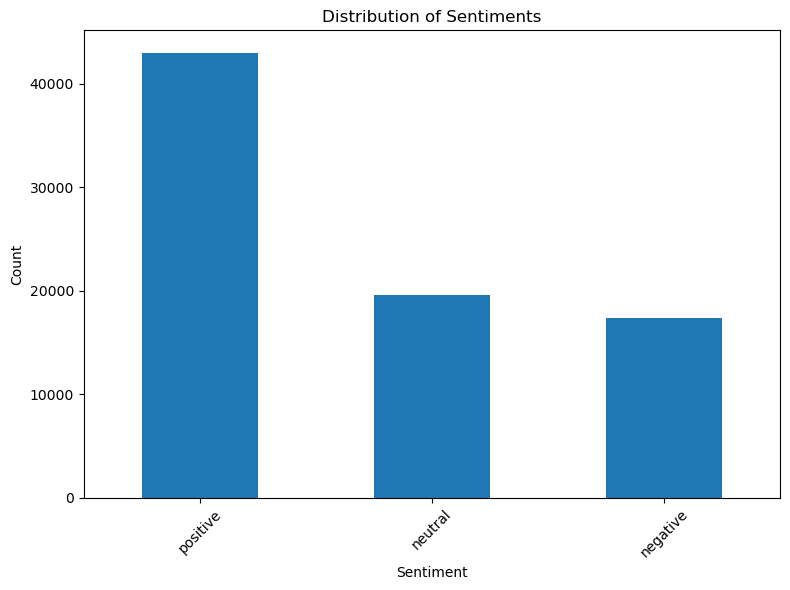

In [16]:
response = requests.get('https://raw.githubusercontent.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/master/data/opinion-lexicon-English/positive-words.txt')
lexicon_positive = {word.strip(): 1 for word in response.text.split('\n') if word.strip() and not word.startswith(';')}

response = requests.get('https://raw.githubusercontent.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/master/data/opinion-lexicon-English/negative-words.txt')
lexicon_negative = {word.strip(): -1 for word in response.text.split('\n') if word.strip() and not word.startswith(';')}

def sentiment_analysis_lexicon(text):
    score = 0
    words = text if isinstance(text, list) else text.split()
    
    for word in words:
        if word in lexicon_positive:
            score += 1
        elif word in lexicon_negative:
            score -= 1
    
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'
    
    return score, polarity

results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon)
results = list(zip(*results))
clean_df['sentiment_score'] = results[0]
clean_df['sentiment'] = results[1]

print("\nSentiment Distribution:")
print(clean_df['sentiment'].value_counts())

plt.figure(figsize=(8, 6))
clean_df['sentiment'].value_counts().plot(kind='bar')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Label Exploration

In [17]:
def create_wordcloud(text_data, title):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100,
        contour_width=3,
        contour_color='steelblue'
    ).generate(' '.join(text_data))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

def get_top_words(text_data, n=10):
    words = ' '.join(text_data).split()
    return pd.DataFrame(Counter(words).most_common(n), columns=['Word', 'Count'])

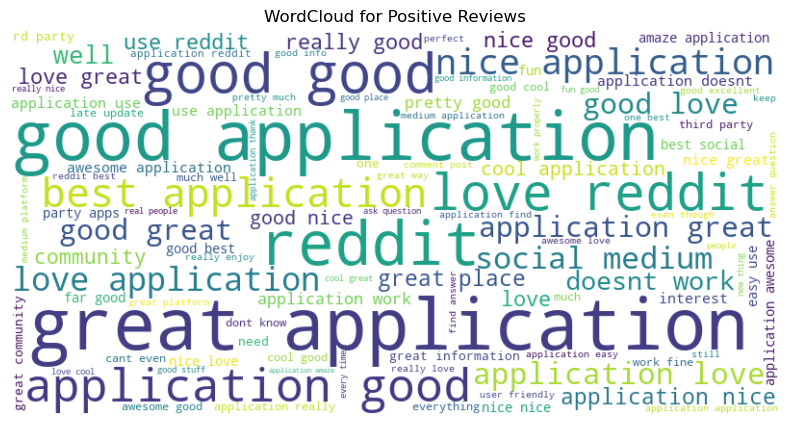

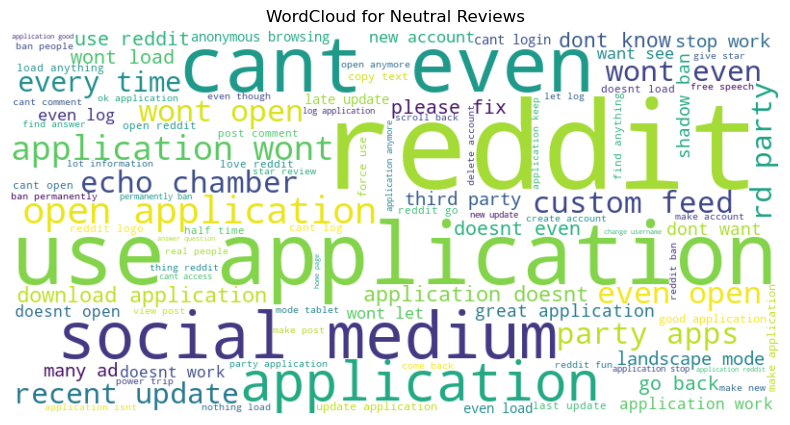

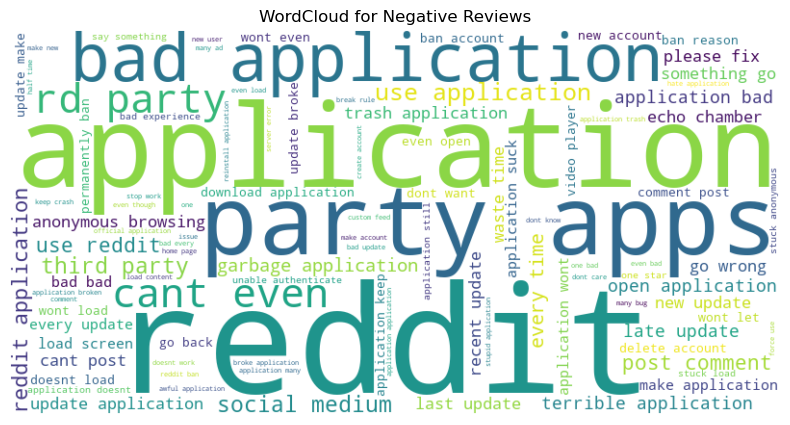

In [18]:
for sentiment in ['positive', 'neutral', 'negative']:
    text_data = clean_df[clean_df['sentiment'] == sentiment]['text_akhir']
    create_wordcloud(text_data, f'WordCloud for {sentiment.title()} Reviews')

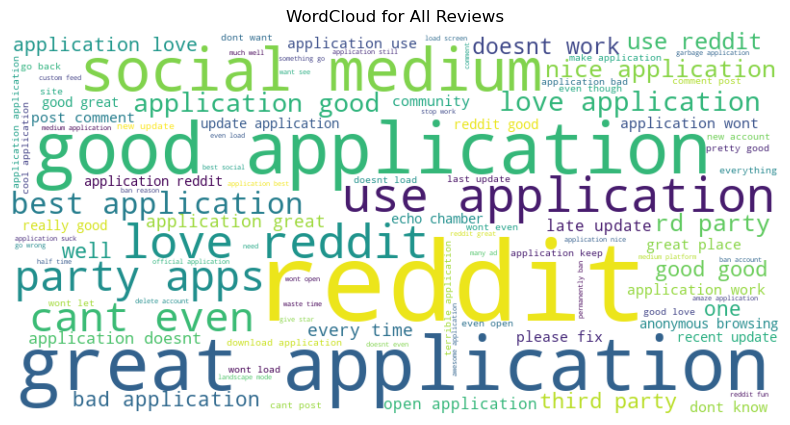

In [19]:
create_wordcloud(clean_df['text_akhir'], 'WordCloud for All Reviews')

### Callback Function dan early_stopping

In [20]:
class Acc92Callback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get("accuracy")
        val_acc = logs.get("val_accuracy")
        if train_acc is not None and val_acc is not None:
            if train_acc >= 0.92 and val_acc >= 0.92:
                print(f"\n🎉 Stopping early at epoch {epoch+1} - Acc > 92% (Train: {train_acc:.4f}, Val: {val_acc:.4f})")
                self.model.stop_training = True

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)

## Experiment 1: TF-IDF + MLP (512-256-128) + Dropout with 54/16/20 Three-Way Split
| Parameter       | Description                        |
|-----------------|------------------------------------|
| **Model Name**  | MLP (512-256-128) + Dropout |
| **Feature**     | TF-IDF with 5k max_features       |
| **Data Split**  | 54% Train, Val 16%, 20% Test                |
| **Optimizer**   | Adam (lr=0.0005)                   |
| **Epochs**      | 50                                 |
| **Batch Size**  | 128                                |
| **Final Accuracy** | 99.24% (Train), 98.96% (Test) - Result May Vary   |

###  Data Splitting & Feature Extraction

In [21]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(clean_df['text_akhir']).toarray().astype(np.float32)

In [22]:
le = LabelEncoder()
y = le.fit_transform(clean_df['sentiment'])

In [23]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

### Modeling

In [24]:
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

mlp_model = Sequential([
    Dense(512, input_shape=(X_train.shape[1],), activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(3, activation='softmax')
])


optimizer = Adam(learning_rate=0.0005)
mlp_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
mlp_model.summary()

/Users/ikrar/Dicoding/Belajar Pengembangan Machine Learning/Submission Analisis Sentimen/env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,725,123 (10.40 MB)

 Trainable params: 2,725,123 (10.40 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [25]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = dict(enumerate(class_weights))

history = mlp_model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=128,
    class_weight=class_weights_dict,
    callbacks=[early_stop, Acc92Callback()],
    verbose=1
)

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.7512 - loss: 1.1481 - val_accuracy: 0.9769 - val_loss: 0.2998
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9793 - loss: 0.2860
🎉 Stopping early at epoch 2 - Acc > 92% (Train: 0.9811, Val: 0.9909)
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.9793 - loss: 0.2860 - val_accuracy: 0.9909 - val_loss: 0.2247
Restoring model weights from the end of the best epoch: 2.


### Evaluation


✅ Akurasi Training Set: 99.24%
✅ Akurasi Testing Set: 98.96%
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


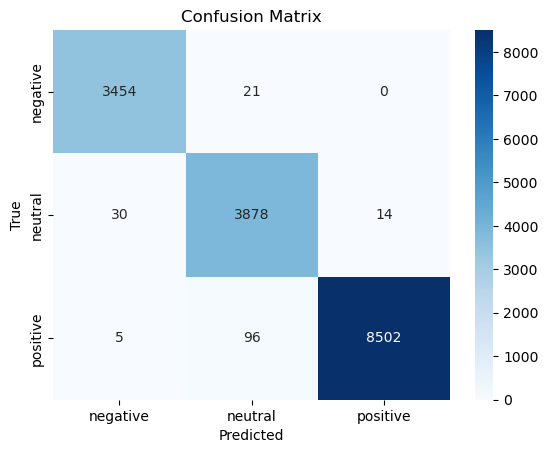


📊 Classification Report:

              precision    recall  f1-score   support

    negative       0.99      0.99      0.99      3475
     neutral       0.97      0.99      0.98      3922
    positive       1.00      0.99      0.99      8603

    accuracy                           0.99     16000
   macro avg       0.99      0.99      0.99     16000
weighted avg       0.99      0.99      0.99     16000



In [26]:
train_loss, train_acc = mlp_model.evaluate(X_train, y_train_cat, verbose=0)
test_loss, test_acc = mlp_model.evaluate(X_test, y_test_cat, verbose=0)

print(f"\n✅ Akurasi Training Set: {train_acc * 100:.2f}%")
print(f"✅ Akurasi Testing Set: {test_acc * 100:.2f}%")

y_pred = mlp_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.array(y_test)

cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\n📊 Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

## Experiment 2: Word Embedding + LSTM With 80/20 Split
| Parameter       | Description                        |
|-----------------|------------------------------------|
| **Model Name**  | LSTM |
| **Feature**     | Word Embedding with 5k num_words       |
| **Data Split**  | 80% Train, 20% Test                |
| **Optimizer**   | Adam                   |
| **Epochs**      | 50                                 |
| **Batch Size**  | 128                                |
| **Final Accuracy** | 99.39% (Train), 99.23% (Test) - Result May Vary   |

### Data Splitting & Feature Extraction

In [27]:
tokenizer_lstm = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer_lstm.fit_on_texts(clean_df['text_akhir'])
sequences = tokenizer_lstm.texts_to_sequences(clean_df['text_akhir'])

X = pad_sequences(sequences, maxlen=100)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(clean_df['sentiment'])
y_cat = to_categorical(y, num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

### Modeling

In [28]:
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(128),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.build(input_shape=(None, 100))
lstm_model.summary()

/Users/ikrar/Dicoding/Belajar Pengembangan Machine Learning/Submission Analisis Sentimen/env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 771,971 (2.94 MB)

 Trainable params: 771,971 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [29]:
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=128,
    class_weight=class_weights_dict,
    callbacks=[early_stop, Acc92Callback()],
    verbose=1
)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - accuracy: 0.7780 - loss: 0.5559 - val_accuracy: 0.9777 - val_loss: 0.0698
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9839 - loss: 0.0585
🎉 Stopping early at epoch 2 - Acc > 92% (Train: 0.9869, Val: 0.9923)
500/500 ━━━━━━━━━━━━━━━━━━━━ 86s 171ms/step - accuracy: 0.9839 - loss: 0.0584 - val_accuracy: 0.9923 - val_loss: 0.0250
Restoring model weights from the end of the best epoch: 2.


### Evaluation


✅ Akurasi Training Set: 99.39%
✅ Akurasi Testing Set: 99.23%
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.99      1.00      3489
     neutral       0.98      0.99      0.98      3969
    positive       0.99      0.99      0.99      8542

    accuracy                           0.99     16000
   macro avg       0.99      0.99      0.99     16000
weighted avg       0.99      0.99      0.99     16000



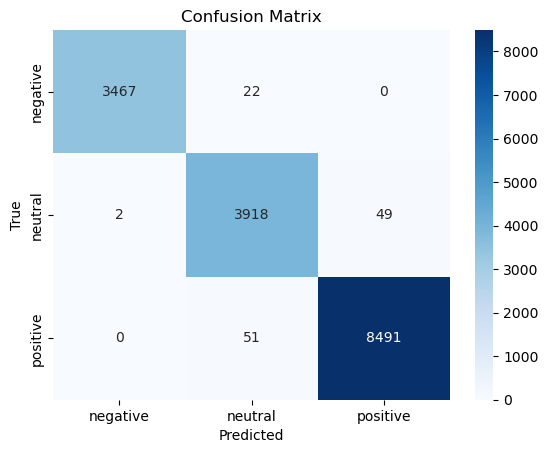

In [30]:
train_loss, train_acc = lstm_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = lstm_model.evaluate(X_test, y_test, verbose=0)

print(f"\n✅ Akurasi Training Set: {train_acc * 100:.2f}%")
print(f"✅ Akurasi Testing Set: {test_acc * 100:.2f}%")

y_pred = lstm_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Experiment 3: Word Embedding + GRU With 54/16/20 Three-Way Split
| Parameter       | Description                        |
|-----------------|------------------------------------|
| **Model Name**  | GRU |
| **Feature**     | Word Embedding     |
| **Data Split**  | 54% Train, Val 16%, 20% Test                 |
| **Optimizer**   | Adam                   |
| **Epochs**      | 50                                 |
| **Batch Size**  | 128                                |
| **Final Accuracy** | 99.63% (Train), 99.33% (Test) - Result May Vary   |

### Data Splitting & Feature Selection

In [31]:
tokenizer_gru = Tokenizer(oov_token="<OOV>")
tokenizer_gru.fit_on_texts(clean_df['text_akhir'])

sequences = tokenizer_gru.texts_to_sequences(clean_df['text_akhir'])

max_len = max(len(seq) for seq in sequences)

X = pad_sequences(sequences, maxlen=max_len)

label_encoder = LabelEncoder()
clean_df['sentiment'] = label_encoder.fit_transform(clean_df['sentiment'])
y = to_categorical(clean_df['sentiment'])

In [32]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42
)

print(f"Train size: {X_train.shape}")
print(f"Val size  : {X_val.shape}")
print(f"Test size : {X_test.shape}")

Train size: (44800, 66)
Val size  : (11200, 66)
Test size : (24000, 66)


### Modeling


In [33]:
gru_model = Sequential([
    Embedding(input_dim=len(tokenizer_gru.word_index) + 1, output_dim=100, input_length=max_len, trainable=True),
    GRU(64),
    Dropout(0.3),
    Dense(64),
    LeakyReLU(alpha=0.1),
    Dense(y.shape[1], activation='softmax')
])
gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gru_model.build(input_shape=(None, 100))
gru_model.summary()

/Users/ikrar/Dicoding/Belajar Pengembangan Machine Learning/Submission Analisis Sentimen/env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/ikrar/Dicoding/Belajar Pengembangan Machine Learning/Submission Analisis Sentimen/env/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │       695,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        31,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 731,627 (2.79 MB)

 Trainable params: 731,627 (2.79 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [34]:
history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    class_weight=class_weights_dict,
    callbacks=[early_stop, Acc92Callback()],
    verbose=1
)

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.7476 - loss: 0.6211 - val_accuracy: 0.9742 - val_loss: 0.0798
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9847 - loss: 0.0553
🎉 Stopping early at epoch 2 - Acc > 92% (Train: 0.9872, Val: 0.9942)
350/350 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.9847 - loss: 0.0553 - val_accuracy: 0.9942 - val_loss: 0.0191
Restoring model weights from the end of the best epoch: 2.


### Evaluation


✅ Akurasi Training Set: 99.63%
✅ Akurasi Testing Set: 99.33%
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.99      1.00      0.99      5213
     neutral       0.99      0.98      0.99      5882
    positive       1.00      1.00      1.00     12905

    accuracy                           0.99     24000
   macro avg       0.99      0.99      0.99     24000
weighted avg       0.99      0.99      0.99     24000



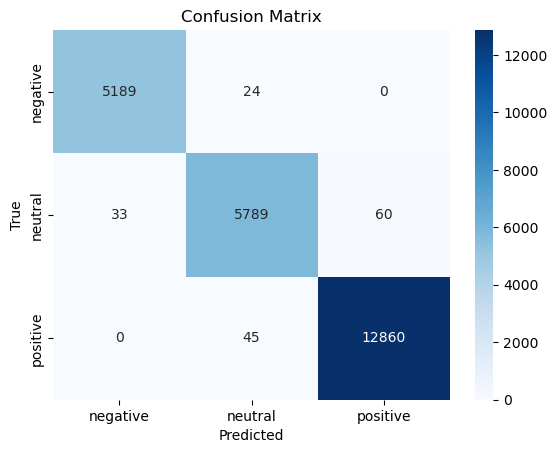

In [35]:
train_loss, train_acc = gru_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = gru_model.evaluate(X_test, y_test, verbose=0)

print(f"\n✅ Akurasi Training Set: {train_acc * 100:.2f}%")
print(f"✅ Akurasi Testing Set: {test_acc * 100:.2f}%")

y_pred = gru_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Model Deployment

In [36]:

label_map = {0: 'negatif', 1: 'netral', 2: 'positif'}

def preprocess_text(text):
    return text.lower().strip()

def predict_sentiment(text, model_type='mlp'):
    """Predict sentiment for a single text input using specified model."""
    processed_text = preprocess_text(text)

    if model_type == 'mlp':
        tfidf_vector = tfidf.transform([processed_text]).toarray()
        pred_probs = mlp_model.predict(tfidf_vector)[0]
        pred_label = np.argmax(pred_probs)
        confidence = pred_probs[pred_label]
    
    elif model_type == 'lstm':
        seq = tokenizer_lstm.texts_to_sequences([processed_text])
        padded = pad_sequences(seq, maxlen=100)
        pred_probs = lstm_model.predict(padded)[0]
        pred_label = np.argmax(pred_probs)
        confidence = pred_probs[pred_label]

    elif model_type == 'gru':
        seq = tokenizer_gru.texts_to_sequences([processed_text])
        padded = pad_sequences(seq, maxlen=100)
        pred_probs = gru_model.predict(padded)[0]
        pred_label = np.argmax(pred_probs)
        confidence = pred_probs[pred_label]

    else:
        raise ValueError("Model type must be 'mlp', 'lstm', or 'gru'")
    
    label = label_encoder.inverse_transform([pred_label])[0]
    return label, confidence


## Inference

In [37]:
sample_reviews = [
    "Best social media app ever",
    "Great app, love the communities!",      
    "App works okay but needs improvement",
    "Terrible app, crashes constantly",                    
    "Amazing platform for discussions",                    
    "garbage app ever, don't download"                      
]

results = []

print("=== Inference Results ===")
for review in sample_reviews:
    mlp_pred, mlp_conf = predict_sentiment(review, 'mlp')
    lstm_pred, lstm_conf = predict_sentiment(review, 'lstm')
    gru_pred, gru_conf = predict_sentiment(review, 'gru')
    
    results.append({
        'Review': review,
        'MLP Prediction': mlp_pred,
        'MLP Confidence': f"{mlp_conf:.4f}",
        'LSTM Prediction': lstm_pred,
        'LSTM Confidence': f"{lstm_conf:.4f}",
        'GRU Prediction': gru_pred,
        'GRU Confidence': f"{gru_conf:.4f}",
    })

df_results = pd.DataFrame(results)
display(df_results)

=== Inference Results ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


,Review,MLP Prediction,MLP Confidence,LSTM Prediction,LSTM Confidence,GRU Prediction,GRU Confidence
0,Best social media app ever,positive,0.9968,positive,0.9989,positive,0.9993
1,"Great app, love the communities!",positive,1.0000,positive,1.0000,positive,1.0000
2,App works okay but needs improvement,neutral,0.6055,positive,0.9361,neutral,0.5206
3,"Terrible app, crashes constantly",negative,0.9990,negative,0.9957,negative,0.9981
4,Amazing platform for discussions,neutral,0.7243,neutral,0.9682,neutral,0.9991
5,"garbage app ever, don't download",negative,0.9491,negative,0.6940,neutral,0.8276
